In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
import random
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from sklearn.model_selection import KFold

#then import my own modules
# from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight
from timeit import default_timer as timer
from AttentiveFP.featurizing import graph_dict
from AttentiveFP.AttentiveLayers_new_resnet import Fingerprint, graph_dataset, null_collate, Graph, Logger, time_to_str



In [2]:
cuda_aviable = torch.cuda.is_available()
device = torch.device(0)

SEED = 8
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic=True


In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer

number of all smiles:  1128
number of successfully processed smiles:  1128


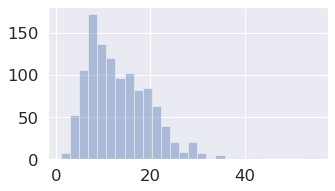

In [4]:
task_name = 'solubility'
tasks = ['measured log solubility in mols per litre']

raw_filename = "../data/delaney-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ", len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)].reset_index()
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()


In [5]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 200

p_dropout= 0.2
fingerprint_dim = 32

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2.5
K = 5
T = 3
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
smiles_list = smiles_tasks_df['smiles'].values
label_list = smiles_tasks_df[tasks[0]].values
graph_dict = graph_dict(smiles_list, label_list, filename)


graph dicts loaded from ../data/delaney-processed.pkl


In [7]:
kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
train_fold = []
valid_fold = []
for k, (train_idx, valid_idx) in enumerate(kfold.split(smiles_list)):
    train_fold.append(train_idx)
    valid_fold.append(valid_idx)
    

In [8]:
valid_fold[2]

array([   1,    3,    5,    8,   13,   15,   25,   27,   33,   47,   49,
         59,   63,   71,   84,   95,   96,  108,  119,  122,  135,  138,
        149,  158,  160,  161,  162,  164,  182,  186,  188,  190,  191,
        203,  211,  213,  219,  221,  223,  227,  228,  234,  240,  260,
        272,  273,  279,  287,  294,  298,  303,  310,  311,  313,  314,
        315,  320,  329,  335,  338,  342,  348,  350,  352,  358,  360,
        370,  371,  373,  375,  395,  401,  402,  407,  409,  412,  420,
        436,  443,  455,  459,  465,  473,  477,  493,  496,  499,  500,
        501,  521,  522,  524,  534,  545,  549,  550,  558,  567,  583,
        590,  592,  601,  604,  606,  608,  615,  621,  622,  623,  629,
        631,  633,  639,  644,  649,  655,  658,  666,  668,  669,  670,
        675,  680,  686,  687,  689,  693,  695,  696,  697,  707,  718,
        719,  725,  726,  731,  741,  745,  751,  753,  757,  760,  764,
        768,  780,  781,  786,  790,  791,  793,  7

In [9]:
loss_function = nn.MSELoss()
model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
model.to(device)

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in  model.parameters()])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

152105
preprocess.0.linear.weight torch.Size([32, 39])
preprocess.0.linear.bias torch.Size([32])
preprocess.0.bn.weight torch.Size([32])
preprocess.0.bn.bias torch.Size([32])
resnetBn.0.0.linear.weight torch.Size([32, 32])
resnetBn.0.0.linear.bias torch.Size([32])
resnetBn.0.0.bn.weight torch.Size([32])
resnetBn.0.0.bn.bias torch.Size([32])
resnetBn.1.0.linear.weight torch.Size([32, 32])
resnetBn.1.0.linear.bias torch.Size([32])
resnetBn.1.0.bn.weight torch.Size([32])
resnetBn.1.0.bn.bias torch.Size([32])
resnetBn.2.0.linear.weight torch.Size([32, 32])
resnetBn.2.0.linear.bias torch.Size([32])
resnetBn.2.0.bn.weight torch.Size([32])
resnetBn.2.0.bn.bias torch.Size([32])
resnetBn.3.0.linear.weight torch.Size([32, 32])
resnetBn.3.0.linear.bias torch.Size([32])
resnetBn.3.0.bn.weight torch.Size([32])
resnetBn.3.0.bn.bias torch.Size([32])
resnetBn.4.0.linear.weight torch.Size([32, 32])
resnetBn.4.0.linear.bias torch.Size([32])
resnetBn.4.0.bn.weight torch.Size([32])
resnetBn.4.0.bn.bias to

In [10]:
def train(smiles_list):
    model.train()
    train_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=True, worker_init_fn=np.random.seed(SEED))
    losses = []
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(train_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        
        loss = loss_function(mol_prediction, label.view(-1,1))     
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    return np.mean(losses)

        
def eval(smiles_list):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    eval_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(eval_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        MAE = F.l1_loss(mol_prediction, label.view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, label.view(-1,1), reduction='none')
        
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(eval_MAE_list).mean(), np.array(eval_MSE_list).mean()


In [11]:
# log = Logger()
# log.open(f'{prefix_filename}_{start_time}.txt')

# f = '{:^5} | {:^7.4f} | {:^7.4f} | {:^7.4f} | {:^7} \n'
# log.write('epoch | loss | train MSE |  valid MSE |  time \n')
# start = timer()

# best_param ={}
# best_param["train_epoch"] = 0
# best_param["valid_epoch"] = 0
# best_param["train_MSE"] = 9e8
# best_param["valid_MSE"] = 9e8

# fold_index = 0
# for epoch in range(800):
#     losses = train(smiles_list[train_fold[fold_index]])
#     traine_MAE, train_MSE = eval(smiles_list[train_fold[fold_index]])
#     valid_MAE, valid_MSE = eval(smiles_list[valid_fold[fold_index]])

#     timing = time_to_str((timer() - start), 'min')  
#     log.write(f.format(epoch, losses, train_MSE, valid_MSE, timing))

#     if train_MSE < best_param["train_MSE"]:
#         best_param["train_epoch"] = epoch
#         best_param["train_MSE"] = train_MSE
#     if valid_MSE < best_param["valid_MSE"]:
#         best_param["valid_epoch"] = epoch
#         best_param["valid_MSE"] = valid_MSE
# #         if valid_MSE < 0.35:
# #              torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
#     if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
#         break
# print(best_param["valid_epoch"],best_param["train_MSE"],best_param["valid_MSE"])

In [12]:

log = Logger()
log.open(f'log/{prefix_filename}_{start_time}.txt')

f = '{:^5} | {:^7.4f} | {:^7.4f} | {:^7.4f} | {:^7} \n'
log.write('epoch | loss | train MSE |  valid MSE |  time \n')
start = timer()

log2 = Logger()
log2.open(f'{prefix_filename}_best_{start_time}.txt')
f2 = '{:^5} | {:^5} | {:^7.4f} | {:^7.4f} \n'

for fold_index in range(5):
    
    model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
    
    best_param ={}
    best_param["train_epoch"] = 0
    best_param["valid_epoch"] = 0
    best_param["train_MSE"] = 9e8
    best_param["valid_MSE"] = 9e8
    for epoch in range(800):
        losses = train(smiles_list[train_fold[fold_index]])
        traine_MAE, train_MSE = eval(smiles_list[train_fold[fold_index]])
        valid_MAE, valid_MSE = eval(smiles_list[valid_fold[fold_index]])
        
        timing = time_to_str((timer() - start), 'min')  
        log.write(f.format(epoch, losses, train_MSE, valid_MSE, timing))
        
        if train_MSE < best_param["train_MSE"]:
            best_param["train_epoch"] = epoch
            best_param["train_MSE"] = train_MSE
        if valid_MSE < best_param["valid_MSE"]:
            best_param["valid_epoch"] = epoch
            best_param["valid_MSE"] = valid_MSE
            if valid_MSE < 0.35:
                 torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
        if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
            break

    log2.write('fold | epoch | train_MSE | valid MSE \n')
    log2.write(f2.format(fold_index, best_param["valid_epoch"],best_param["train_MSE"],best_param["valid_MSE"]))
    
    

epoch | loss | train MSE |  valid MSE |  time 
  0   | 12.6553 | 11.5771 | 11.5978 |  0 hr 00 min 
  1   | 4.2940  | 6.8260  | 6.9524  |  0 hr 00 min 
  2   | 2.1169  | 2.9474  | 3.7891  |  0 hr 00 min 
  3   | 2.5129  | 3.5664  | 4.4849  |  0 hr 00 min 
  4   | 1.9650  | 3.8425  | 4.2641  |  0 hr 00 min 
  5   | 1.3013  | 2.1679  | 2.7987  |  0 hr 00 min 
  6   | 1.1227  | 1.7325  | 2.2356  |  0 hr 00 min 
  7   | 1.1166  | 1.3496  | 1.6748  |  0 hr 00 min 
  8   | 0.9252  | 1.0690  | 1.3680  |  0 hr 00 min 
  9   | 0.9163  | 1.1103  | 1.4896  |  0 hr 00 min 
 10   | 0.8691  | 0.7510  | 0.9832  |  0 hr 00 min 
 11   | 0.7727  | 0.6582  | 0.8540  |  0 hr 00 min 
 12   | 0.7035  | 0.5703  | 0.8128  |  0 hr 00 min 
 13   | 0.6015  | 0.5194  | 0.7059  |  0 hr 00 min 
 14   | 0.5492  | 0.4447  | 0.7162  |  0 hr 00 min 
 15   | 0.5076  | 0.4117  | 0.6563  |  0 hr 00 min 
 16   | 0.4866  | 0.3775  | 0.5997  |  0 hr 00 min 
 17   | 0.4821  | 0.3642  | 0.6176  |  0 hr 00 min 
 18   | 0.4500  |

 59   | 0.3362  | 0.1404  | 0.3787  |  0 hr 04 min 
 60   | 0.2625  | 0.1366  | 0.3775  |  0 hr 04 min 
 61   | 0.2354  | 0.1895  | 0.4057  |  0 hr 04 min 
 62   | 0.2617  | 0.1856  | 0.3801  |  0 hr 04 min 
 63   | 0.2520  | 0.1930  | 0.4504  |  0 hr 04 min 
 64   | 0.2379  | 0.1651  | 0.3868  |  0 hr 04 min 
 65   | 0.2615  | 0.1388  | 0.3646  |  0 hr 04 min 
 66   | 0.2385  | 0.1569  | 0.3782  |  0 hr 04 min 
 67   | 0.2342  | 0.1673  | 0.3841  |  0 hr 04 min 
 68   | 0.2391  | 0.1577  | 0.3946  |  0 hr 04 min 
 69   | 0.2077  | 0.1350  | 0.3933  |  0 hr 04 min 
 70   | 0.2108  | 0.1257  | 0.3685  |  0 hr 04 min 
 71   | 0.2159  | 0.1231  | 0.3496  |  0 hr 04 min 
 72   | 0.1892  | 0.1310  | 0.3108  |  0 hr 04 min 
 73   | 0.2459  | 0.1243  | 0.3502  |  0 hr 04 min 
 74   | 0.2585  | 0.1761  | 0.4486  |  0 hr 04 min 
 75   | 0.2325  | 0.1107  | 0.3413  |  0 hr 05 min 
 76   | 0.2297  | 0.1914  | 0.4540  |  0 hr 05 min 
 77   | 0.1927  | 0.1495  | 0.4151  |  0 hr 05 min 
 78   | 0.19

 30   | 0.3047  | 0.2238  | 0.3728  |  0 hr 09 min 
 31   | 0.3258  | 0.1925  | 0.3338  |  0 hr 09 min 
 32   | 0.2718  | 0.1940  | 0.3250  |  0 hr 09 min 
 33   | 0.2675  | 0.1811  | 0.3199  |  0 hr 09 min 
 34   | 0.2913  | 0.1862  | 0.3653  |  0 hr 09 min 
 35   | 0.3955  | 0.1662  | 0.3461  |  0 hr 09 min 
 36   | 0.2820  | 0.1943  | 0.3470  |  0 hr 09 min 
 37   | 0.2728  | 0.1767  | 0.3434  |  0 hr 09 min 
 38   | 0.2828  | 0.1914  | 0.3670  |  0 hr 09 min 
 39   | 0.2983  | 0.1854  | 0.3535  |  0 hr 09 min 
 40   | 0.2928  | 0.1667  | 0.3252  |  0 hr 09 min 
 41   | 0.2482  | 0.1741  | 0.3034  |  0 hr 09 min 
 42   | 0.2549  | 0.1572  | 0.3245  |  0 hr 09 min 
 43   | 0.2574  | 0.1919  | 0.3436  |  0 hr 09 min 
 44   | 0.2666  | 0.1763  | 0.3644  |  0 hr 09 min 
 45   | 0.2795  | 0.1693  | 0.3423  |  0 hr 09 min 
 46   | 0.2524  | 0.1570  | 0.3168  |  0 hr 09 min 
 47   | 0.2499  | 0.1386  | 0.3107  |  0 hr 09 min 
 48   | 0.2267  | 0.1576  | 0.3370  |  0 hr 09 min 
 49   | 0.22

 70   | 0.2311  | 0.1147  | 0.4205  |  0 hr 14 min 
 71   | 0.2346  | 0.1196  | 0.4235  |  0 hr 14 min 
 72   | 0.2518  | 0.1371  | 0.4152  |  0 hr 14 min 
 73   | 0.2288  | 0.1265  | 0.4235  |  0 hr 14 min 
 74   | 0.2961  | 0.2058  | 0.4659  |  0 hr 14 min 
 75   | 0.1925  | 0.1337  | 0.4254  |  0 hr 14 min 
 76   | 0.2063  | 0.1540  | 0.4241  |  0 hr 14 min 
 77   | 0.2312  | 0.1283  | 0.4139  |  0 hr 14 min 
 78   | 0.2124  | 0.1397  | 0.4587  |  0 hr 14 min 
 79   | 0.1916  | 0.1252  | 0.4194  |  0 hr 14 min 
 80   | 0.1927  | 0.1055  | 0.4057  |  0 hr 14 min 
 81   | 0.1756  | 0.1269  | 0.4136  |  0 hr 14 min 
 82   | 0.1808  | 0.1071  | 0.4659  |  0 hr 14 min 
 83   | 0.1793  | 0.1051  | 0.4147  |  0 hr 14 min 
 84   | 0.1870  | 0.1068  | 0.4131  |  0 hr 14 min 
 85   | 0.1932  | 0.0971  | 0.4198  |  0 hr 14 min 
 86   | 0.1791  | 0.1087  | 0.4025  |  0 hr 14 min 
 87   | 0.1629  | 0.1217  | 0.4834  |  0 hr 14 min 
 88   | 0.1836  | 0.1001  | 0.4313  |  0 hr 14 min 
 89   | 0.20

In [13]:
# # evaluate model
# best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()
# test_MAE, test_MSE = eval(model, test_df)
# print("best epoch:",best_param["test_epoch"],"\n","test MSE:",test_MSE)

In [14]:
# for e in range(20):
#     losses = train(smiles_list[valid_fold[fold_index]])
#     print(losses)